<img src="https://mma.prnewswire.com/media/357911/Santander_Logo.jpg?p=publish" alt="drawing" width="300"/><br>
Santander Bank, N. A., formerly Sovereign Bank, is a wholly owned subsidiary of the Spanish Santander Group. It is based in Boston and its principal market is the northeastern United States. It has $57.5 billion in deposits, operates about 650 retail banking offices and over 2,000 ATMs, and employs approximately 9,800 people. It offers an array of financial services and products including retail banking, mortgages, corporate banking, cash management, credit card, capital markets, trust and wealth management, and insurance.<br>


---


### *Santander Customer Transaction Prediction*
In this challenge, you have to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data.<br> Kaggle dataset: https://www.kaggle.com/c/-customer-transaction-prediction/data


## Read Dataset

In [30]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, shapiro, zscore


sns.set_theme(style="darkgrid")       # Set themes for plots
drive.mount('/content/gdrive')        # Connect to Google Drive
warnings.filterwarnings("ignore")     # Ignore Warnings

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
# Reading data
train = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/test.csv')

# Shape of the data
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}')

Train data: (200000, 202)
Test data: (200000, 201)


In [32]:
# Head of train data
train.head(3)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965


In [33]:
# Checking for null values
train.isnull().values.any()

False

In [34]:
# Checking Datatypes
dtypes = pd.DataFrame(train.dtypes)
dtypes.T

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## Feature Importance Using Random Forest Classifier
Since all the 200 features are anonymous, I will be considering top 15 important features by running Random Forest classifier.

In [35]:
from sklearn.ensemble import RandomForestClassifier

X = train.iloc[:, 2:]                    # Features
y = train.iloc[:, 1]                     # Target variable

model = RandomForestClassifier()         # Define the model
model.fit(X, y)                          # Fit the model
importance = model.feature_importances_  # Get important features

In [36]:
important_features = pd.DataFrame({'Features': train.iloc[:, 2:].columns.values, 'Importance': list(importance)})
important_features = important_features.sort_values(by='Importance', ascending=False).set_index('Features')

features = list(important_features.index[:15])                                    # Selecting 15 important features
features.append('target')                                                         # Adding target variable
df_feats = train[features]                                                        # Selecting important features
print(f'Top 15 features:\n {df_feats.columns.values}')                            # Feature names

Top 15 features:
 ['var_81' 'var_12' 'var_139' 'var_110' 'var_53' 'var_26' 'var_174'
 'var_146' 'var_22' 'var_166' 'var_6' 'var_109' 'var_76' 'var_80' 'var_99'
 'target']


In [37]:
# Top 15 important features
df_feats.head(3)

,var_81,var_12,var_139,var_110,var_53,var_26,var_174,var_146,var_22,var_166,var_6,var_109,var_76,var_80,var_99,target
0,13.8372,14.0137,15.6599,2.0323,5.1736,-5.1488,18.5618,11.5659,2.5791,2.7004,5.1187,24.3627,-2.3440,13.6468,-3.4132,0
1,18.1782,14.0239,16.1622,6.6203,6.6885,-11.7684,30.2645,8.9231,8.5524,3.2003,5.6208,13.0858,3.2709,2.5462,0.6939,0
2,15.7811,14.1929,8.6674,3.2304,6.4059,-7.9940,25.6820,11.4934,1.2145,3.2790,6.9427,20.3882,4.5048,7.4729,-0.0269,0


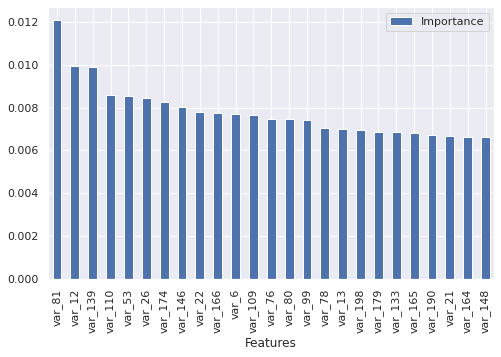

In [38]:
important_features.iloc[:25, ].plot.bar(figsize=(8,5));

Text(0, 0.5, 'Importance')

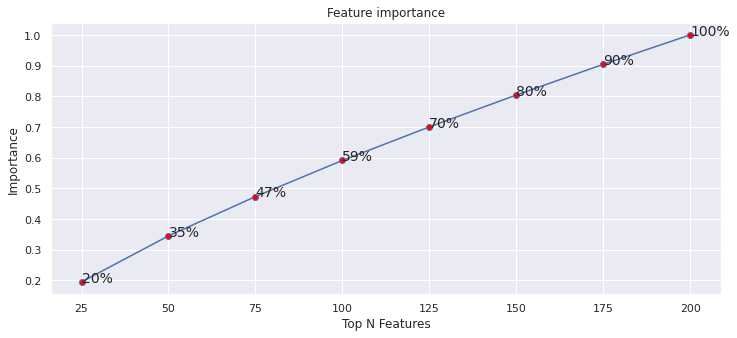

In [39]:
sum_importance = []
for i in range(25, 225, 25):
  sum_importance.append(important_features.iloc[:i, ].sum())

x = [i for i in range(25, 225, 25)]
y = sum_importance
plt.figure(figsize=(12, 5))
plt.plot(x, y, marker='o', mfc='red');
for a,b in zip(x, y): 
    plt.annotate(str(round(b[0]*100))+'%',xy=(a,b), fontsize=14)

plt.title('Feature importance')
plt.xlabel('Top N Features')
plt.ylabel('Importance')

## Feature Selection Using Analysis of Variance (ANOVA)
- Null Hypothesis – There is no significant difference among 2 groups, i.e., Transaction and No Transaction
- Alternate Hypothesis – There is a significant difference among the groups

In [40]:
df_feats = train[['var_81', 'var_139', 'var_12', 'var_53', 'var_26', 'var_110', 'var_174', 'var_146', 'var_166', 'var_109', 'var_22', 'var_6', 'var_80', 'var_99', 'var_76', 'target']]


In [41]:
# Reference: https://www.youtube.com/watch?v=8SmbLFH80To&t=503s

from sklearn.feature_selection import SelectKBest     # Select features according to the k highest scores.
from sklearn.feature_selection import f_classif       # Compute the ANOVA F-value for the provided sample.

X = df_feats.iloc[:, :-1]
y = df_feats.iloc[:, -1]

selector = SelectKBest(f_classif, k=15)
selector.fit(X, y)

SelectKBest(k=15, score_func=<function f_classif at 0x7ff4fbcaca70>)

In [42]:
cols = selector.get_support(indices=True)
anova_feats = pd.DataFrame({'Features': X.iloc[:,cols].columns.values, 'Importance': selector.scores_})
anova_feats

,Features,Importance
0,var_81,1318.140513
1,var_139,1103.603770
2,var_12,970.428385
3,var_53,807.112785
4,var_26,782.346677
5,var_110,829.682225
6,var_174,763.510862
7,var_146,813.395373
8,var_166,669.773502
9,var_109,499.761820


In [43]:
# Common Features Using ANOVA and Random Forest Classifier

rfc_feats = ['var_81', 'var_139', 'var_12', 'var_53', 'var_26', 'var_110', 'var_174', 'var_146', 'var_166', 'var_109', 'var_22', 'var_6', 'var_80', 'var_99', 'var_76']
anova_feats = ['var_81', 'var_139', 'var_12', 'var_53', 'var_26', 'var_110', 'var_174', 'var_146', 'var_166', 'var_109', 'var_22', 'var_6', 'var_80', 'var_99', 'var_76']

df_impt = pd.DataFrame({'RFC Features': rfc_feats, 'ANOVA Features': anova_feats})
df_impt

,RFC Features,ANOVA Features
0,var_81,var_81
1,var_139,var_139
2,var_12,var_12
3,var_53,var_53
4,var_26,var_26
5,var_110,var_110
6,var_174,var_174
7,var_146,var_146
8,var_166,var_166
9,var_109,var_109


Using Random forest classifier feature importance and ANOVA's select k feature, we get the same variables. We can consider these 15 variables for EDA

## Counts of Target Variable

Target Variable Count in Percentage


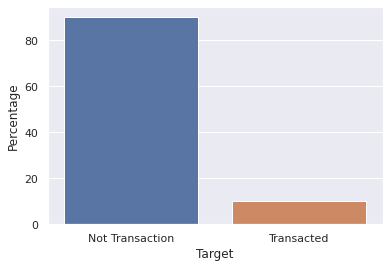

In [44]:
# Counting Dependent Variable
print('Target Variable Count in Percentage')
target_df = pd.DataFrame({'Target':['Not Transaction', 'Transacted'], 'Percentage': round(train.iloc[:, 1].value_counts(normalize=True)*100)})
sns.barplot(x='Target', y='Percentage', data=target_df);

## Test for Normality of Features

In [45]:
# Test for Normality

def normaltest_test(df):
  """
  Test for normality of continuous variables
  - D’Agostino’s K-squared test
  - If the p-value ≤ alpha, we assume the distribution of our variable is not gaussian.
  """
  var = []
  alpha = 0.01
  for i in df.columns.values:
    p_value = normaltest(train[i].to_numpy())[1]
    if p_value > alpha:
      var.append(i)
  if var == []:
    print('D’Agostino’s K-squared test: None of the features follow gaussian distribution')
  else:
    print(f'D’Agostino’s K-squared test: Features following gaussian distribution are {var}')


def shapiro_test(df):
  """
  Test for normality of continuous variables
  - Shapiro-Wilk test is believed to be more reliable test of normality
  - If the p-value ≤ alpha, we assume the distribution of our variable is not gaussian.
  """
  var = []
  alpha = 0.01
  for i in df.columns.values:
    p_value = shapiro(train[i].to_numpy())[1]
    if p_value > alpha:
      var.append(i)
  if var == []:
    print('shapiro test: None of the features follow gaussian distribution')
  else:
    print(f'shapiro test: Features following gaussian distribution are {var}')

normaltest_test(X)
shapiro_test(X)

D’Agostino’s K-squared test: None of the features follow gaussian distribution
shapiro test: None of the features follow gaussian distribution


## Correlation

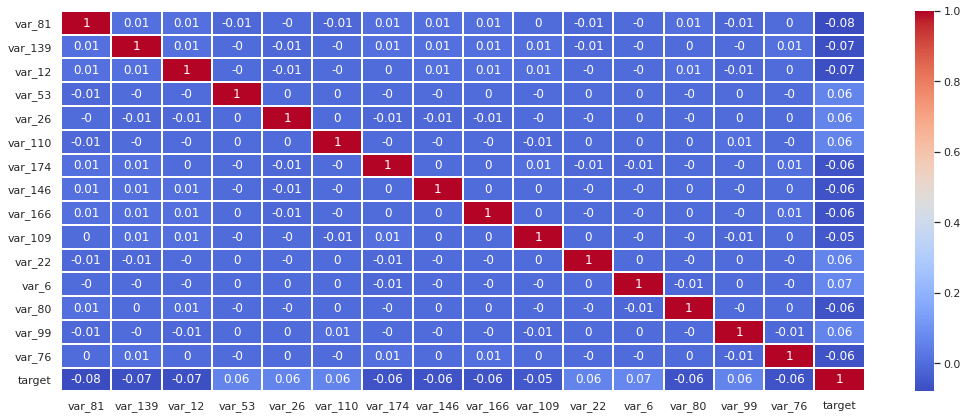

In [46]:
# Correlation among important variables
corr = round(df_feats.corr(), 2)
plt.figure(figsize=(18,7))
sns.heatmap(corr, cmap="coolwarm", annot=True, linewidths=1);